In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils import data
import seaborn as sn
import pandas as pd
from tqdm import tqdm
plt.ion()   # interactive mode

# Install Necessary Module to Download Data

In [2]:
! pip install git+https://github.com/Joeclinton1/google-images-download.git

In [2]:
folder_path = 'downloads/'
model_name = 'Dog Breed Classifier'

In [ ]:
# importing google_images_download module
from google_images_download import google_images_download

# creating object
response = google_images_download.googleimagesdownload()

search_queries = [
'Beagle',
'Golden Retriever',
'Mini Australian Shepherd',
'Broad Collie',
'Corgi',
'Labrador Retriever',
'French Bulldog'
]


def downloadimages(query):
	# keywords is the search query
	# format is the image file format
	# limit is the number of images to be downloaded
	# print urs is to print the image file url
	# size is the image size which can
	# be specified manually ("large, medium, icon")
	# aspect ratio denotes the height width ratio
	# of images to download. ("tall, square, wide, panoramic")
	arguments = {"keywords": query,
				"format": "jpg",
				"limit":100,
				"print_urls":True,
				"size": "medium",
				"aspect_ratio":"panoramic"
                }
	try:
		response.download(arguments)
	
	# Handling File NotFound Error	
	except FileNotFoundError:
		arguments = {"keywords": query,
					"format": "jpg",
					"limit":100,
					"print_urls":True,
					"size": "medium"}
					
		# Providing arguments for the searched query
		try:
			# Downloading the photos based
			# on the given arguments
			response.download(arguments)
		except:
			pass

# Driver Code
for query in search_queries:
	downloadimages(query)
	print()


# Load and Split Image Data

In [4]:
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         SquarePad(),
        transforms.Resize((224,224)),
#         transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
#         transforms.Normalize(mean, std)
    ])

images = datasets.ImageFolder(os.path.join(folder_path),transform)
data_size = len(images.imgs)
train_size = int(data_size*0.8)
val_size = (data_size-train_size)//2
test_size = data_size-train_size-val_size
train_set, val_set, test_set = data.random_split(images, (train_size,val_size,test_size))
image_datasets = {'train':train_set, 'val':val_set,'test':test_set}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = images.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
dataset_sizes

{'train': 607, 'val': 76, 'test': 76}

torch.Size([224, 224])


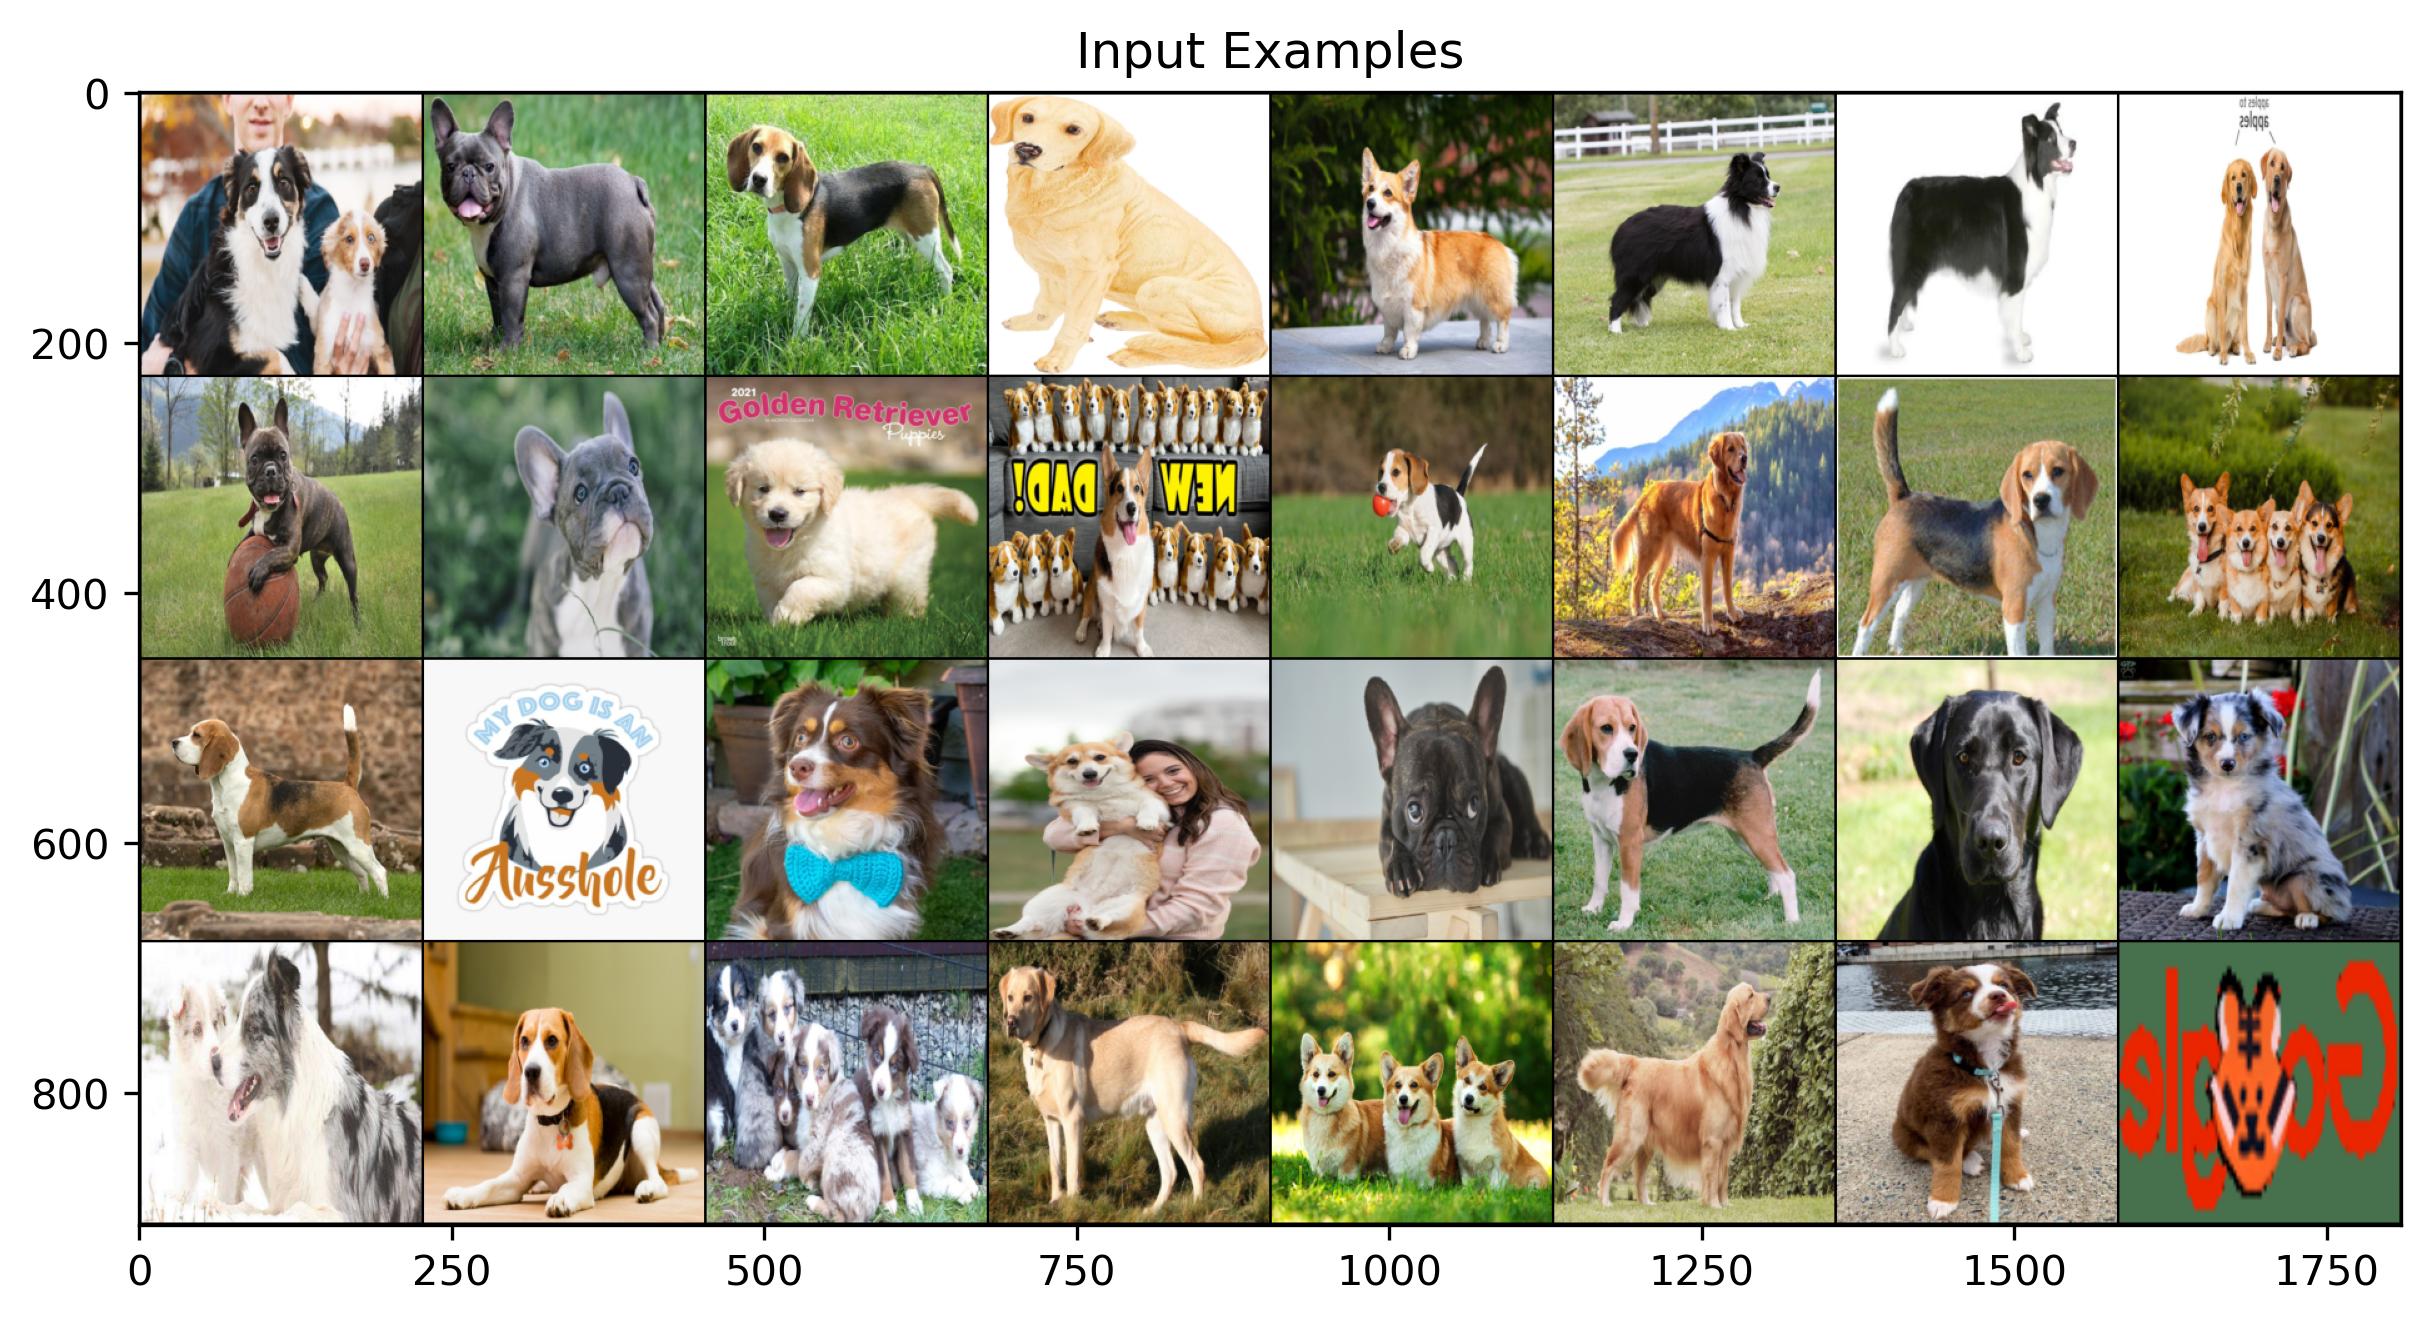

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated
#     plt.savefig('input samples.png')

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs[0][0].shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(20,5),dpi=300)
imshow(out, title='Input Examples')
plt.savefig(model_name+'Input Samples.png')


# Build Model

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=16):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(20,20),dpi=300)
    sm = torch.nn.Softmax()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            l=labels
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            confidence = np.amax(np.array(sm(outputs.cpu())),1)
#             break
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//4, 4, images_so_far)
                ax.set_xlabel('Grountruth: {}'.format(class_names[l[j]]))
                ax.set_ylabel('Prediction: {}'.format(class_names[preds[j]]))
                ax.set_title('Confidence {:.2f}'.format(confidence[j]))
                
#                 imshow(inputs.cpu().data[j])
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))

#                 inp = std * inp + mean
                inp = np.clip(inp, 0, 1)    
                ax.imshow(inp)
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


# Train Model

In [9]:
model_ft = models.resnet18(pretrained=True)
# model_ft = torch.load('ResNet18.pth')
# model.eval()

# model_ft = models.resnet18(pretrained=False)
# model_ft.load_state_dict(torch.load("ResNet18.pth"))
# model_ft.eval()

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [10]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 1.7179 Acc: 0.3657
val Loss: 1.2131 Acc: 0.6842

Epoch 1/4
----------
train Loss: 0.7870 Acc: 0.8254
val Loss: 0.6432 Acc: 0.8026

Epoch 2/4
----------
train Loss: 0.4757 Acc: 0.8781
val Loss: 0.5159 Acc: 0.8553

Epoch 3/4
----------
train Loss: 0.3761 Acc: 0.9077
val Loss: 0.4665 Acc: 0.8684

Epoch 4/4
----------
train Loss: 0.3155 Acc: 0.9077
val Loss: 0.4522 Acc: 0.8816

Training complete in 1m 22s
Best val Acc: 0.881579


<ipython-input-8-fd872ea3958b>:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence = np.amax(np.array(sm(outputs.cpu())),1)


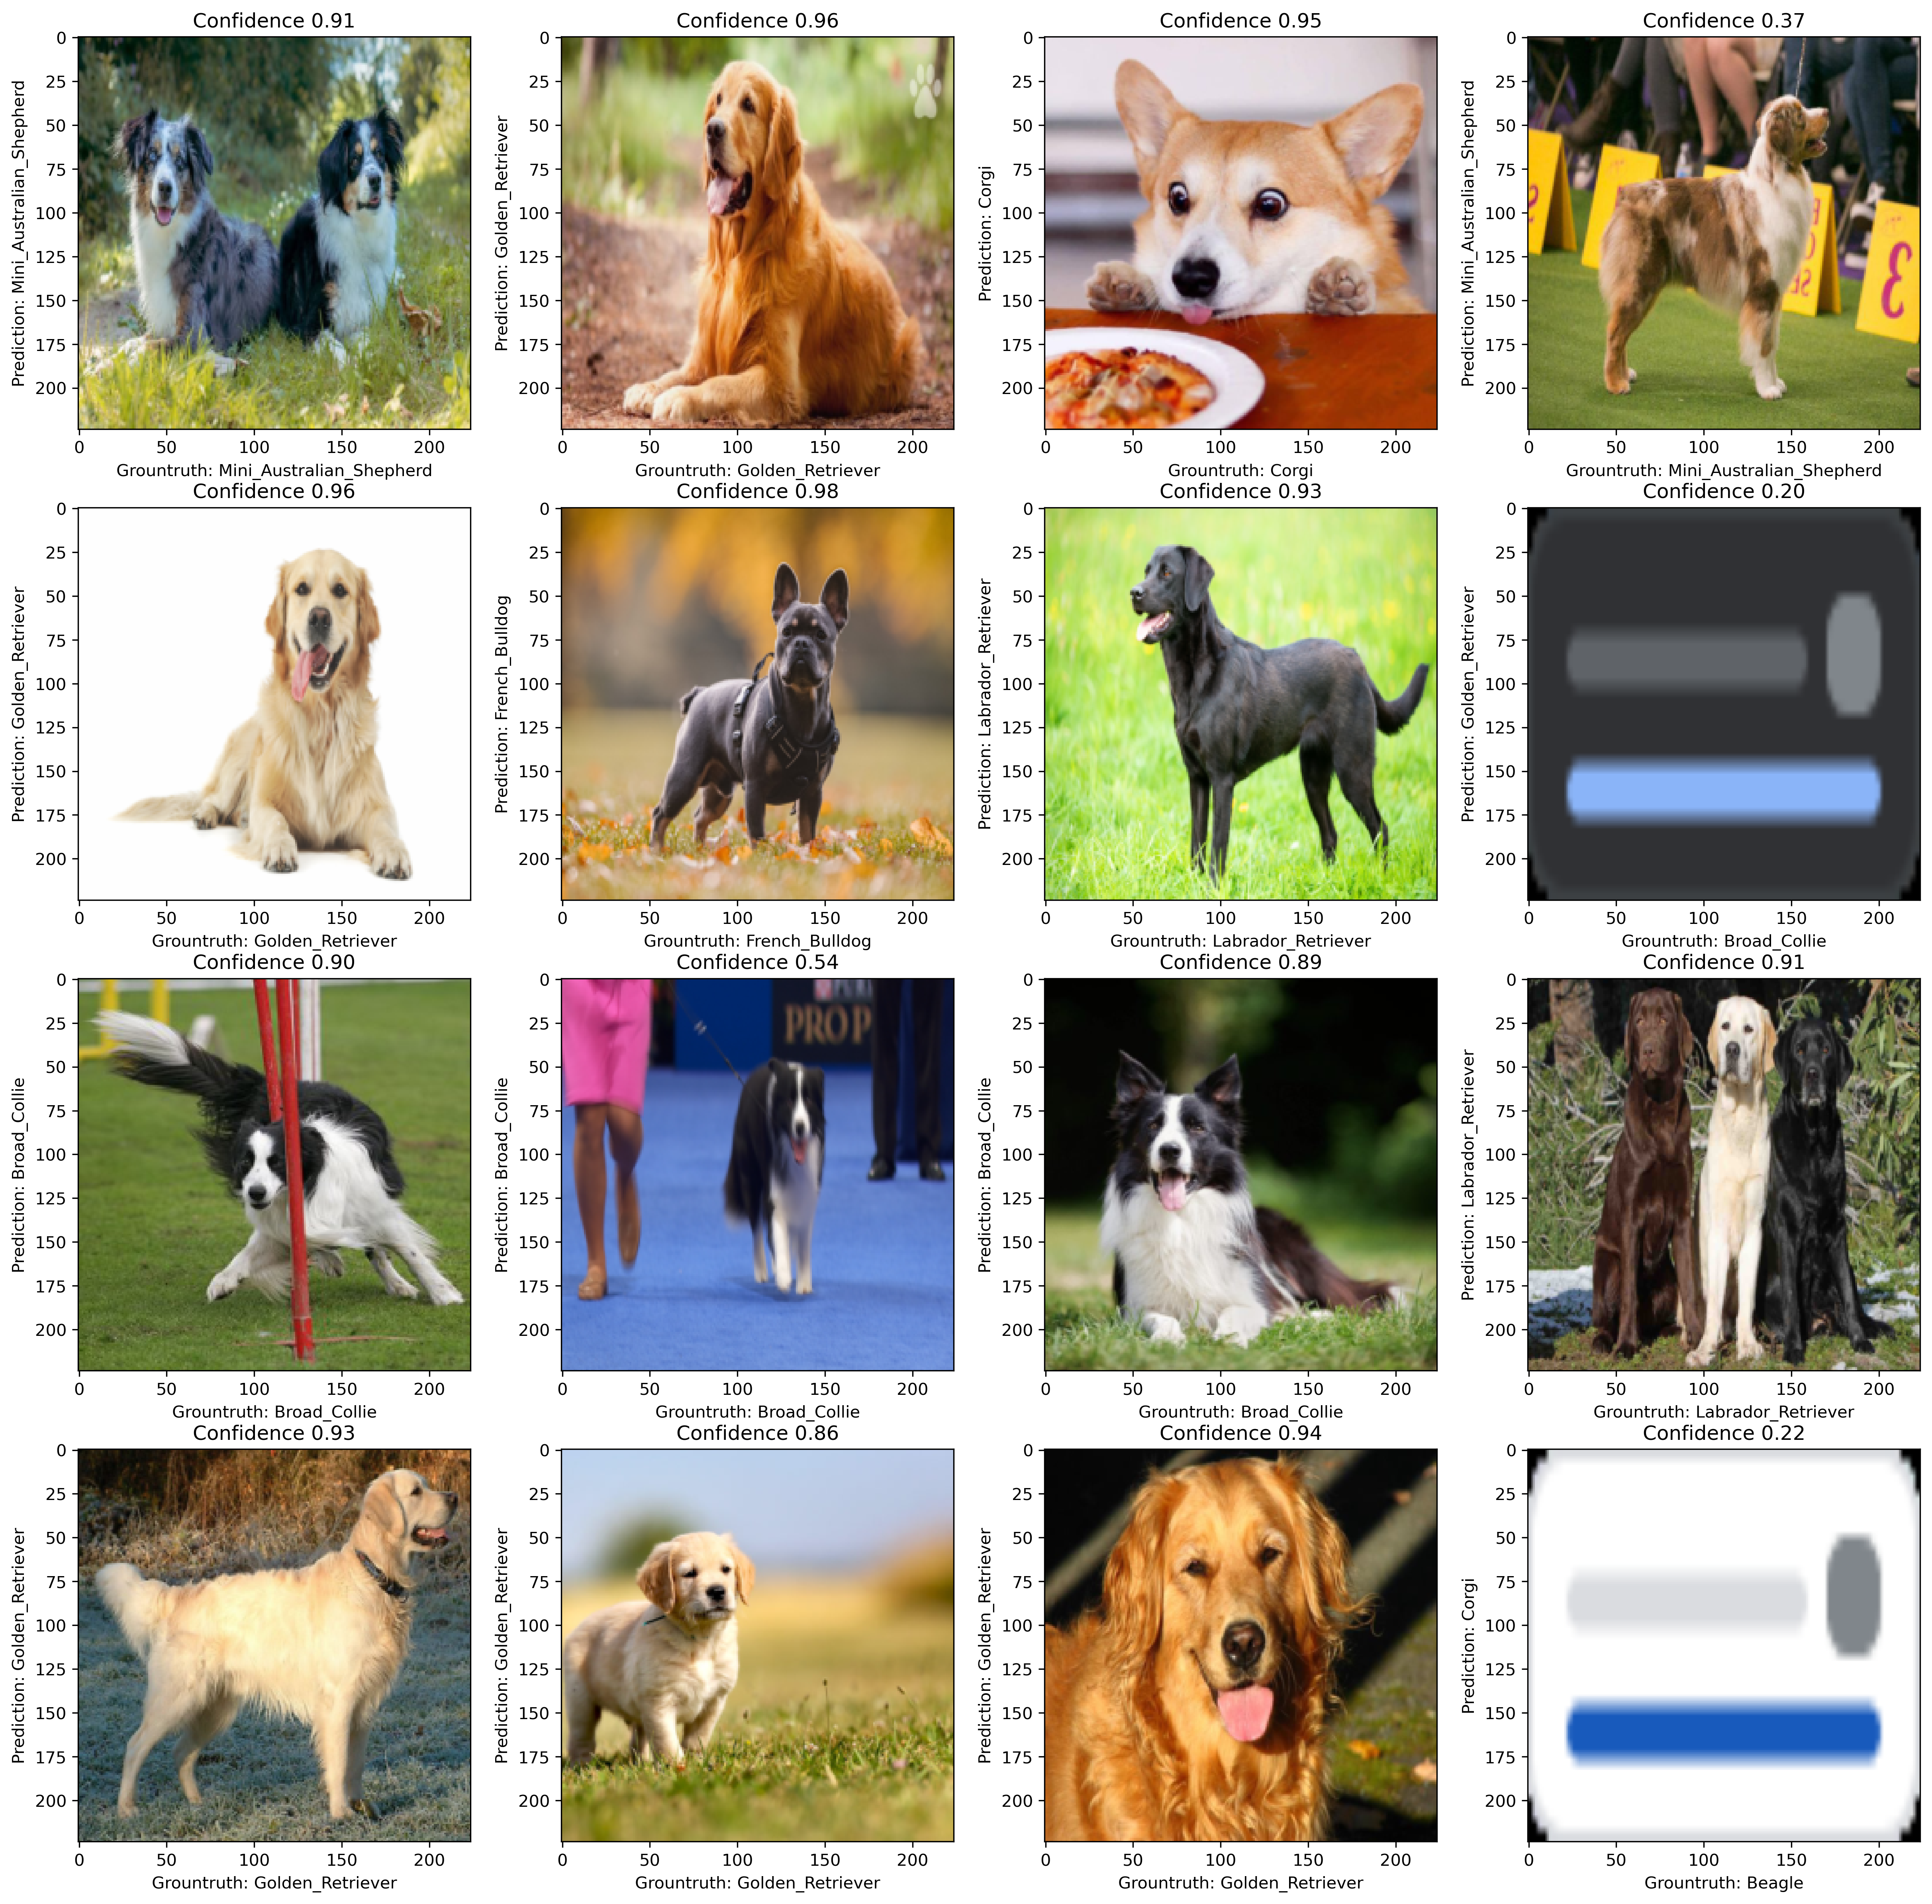

In [12]:
visualize_model(model_ft)
plt.savefig(model_name+'.png')

In [13]:
torch.save(model_ft, model_name+'.pth')

# Output Format

This is a French Bulldog


<ipython-input-24-b6f3d3ccb620>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidences = np.array(sm(out.cpu()))


<AxesSubplot:>

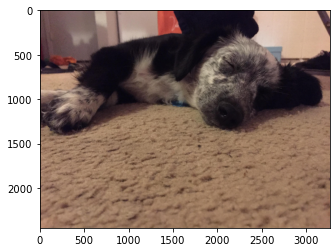

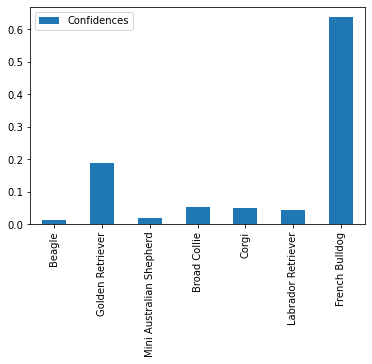

In [24]:
from PIL import Image
import torchvision.transforms.functional as TF

image = Image.open('Ellie/Ellie (3).jpg')
plt.imshow(image)
resize = TF.resize(image, size=(224,224))
x = TF.to_tensor(resize)
x=x.to(device).unsqueeze(0)

with torch.no_grad():
    model_apply = models.resnet18(pretrained=False)
    model_apply = torch.load(model_name+'.pth')
    model_apply.eval()
    out = model_apply(x)
    _, preds = torch.max(out, 1)
print('This is a {}'.format(search_queries[preds]))
sm = torch.nn.Softmax()       
confidences = np.array(sm(out.cpu()))
df = pd.DataFrame({'Confidences':confidences[0]},index=search_queries)
df.plot.bar()


In [ ]:
confidences

In [ ]:
lst

# Confusion Matrix Result Analysis

In [ ]:
nb_classes = len(class_names)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

In [ ]:
df_cm = pd.DataFrame(confusion_matrix.numpy().astype('int'), index = [i for i in class_names],
                  columns = [i for i in class_names])

test_acc=np.trace(confusion_matrix.numpy().astype('int'))/np.sum(np.sum(df_cm))
df_cm.to_csv(model_name+'.csv')
plt.figure(figsize = (len(class_names)//2,len(class_names)//2))
plt.title('Confusing Matrix of Ground-truth (row) and Prediction (column) with Testing Accuracy: {:0.2f}%'.format(test_acc*100))
sn.heatmap(df_cm, annot=True,fmt='g',cmap="YlGnBu")
plt.savefig(model_name+'Confusing Matrix.png')

In [ ]:
nor = df_cm / np.array([df_cm.sum(axis=1)]*len(class_names)).transpose()
plt.figure(figsize = (len(class_names)//2,len(class_names)//2))
plt.title('Normalized Confusing Matrix (%) of Ground-truth (row) and Prediction (column) with Testing Accuracy: {:0.2f}%'.format(test_acc*100))
sn.heatmap(nor*100, annot=True,fmt='.0f',cmap="Greens")
plt.savefig(model_name+'Confusing Matrix(%).png')